# Egg Card Segmentation & Text Extraction

We test basic contour extraction methods to segment boxes within cards. We also test basic OCR tools to extract text from within boxes.

#### Imports

In [1]:
import numpy as np
import skimage.io as io
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage import measure
from skimage.filters import threshold_otsu
from copy import deepcopy
import cv2
import imutils
import tqdm
from skimage import feature
import pytesseract
import re

#### Data

In [2]:
path_to_images = '/home/arias1/Documents/GitHub/egg_cards/Images/Drawer_1/Usable'
image_path = path_to_images+'/'+'001-0001.jpg'
image = io.imread(image_path)

### Boundary Function
Function to create bounds to classify whether a contour is a _box_.

In [3]:
def get_max_bounds(contours,xbound=10,ybound=12):
    all_x_coords = []
    for contour in contours:
        all_x_coords.extend(contour[:,1])
        
    all_y_coords = []
    for contour in contours:
        all_y_coords.extend(contour[:,0])
        
    min_x,max_x = [min(all_x_coords),max(all_x_coords)]
    min_y,max_y = [min(all_y_coords),max(all_y_coords)]
    
    xb = (max_x-min_x)/xbound
    yb = (max_y-min_y)/ybound
    
    return xb,yb

### Contour Extraction on Binarized Image

In [4]:
thresh = threshold_otsu(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
binary = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) > thresh
contours = measure.find_contours(binary, 0.8)

In [5]:
contours_lengths = [len(c[:,0]) for c in contours]
lower_quartile = np.percentile(contours_lengths,25)
median = np.percentile(contours_lengths,50)
upper_quartile = np.percentile(contours_lengths,75)

In [6]:
range_x_lower_bound,range_y_lower_bound = get_max_bounds(contours)

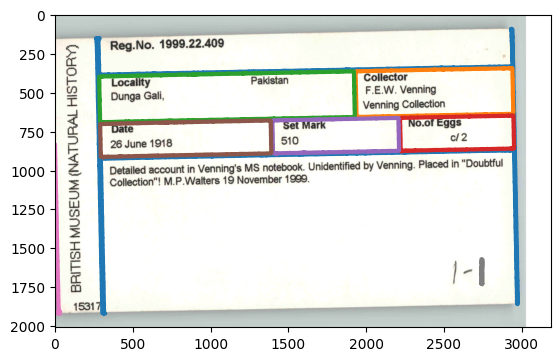

In [7]:
fig,ax = plt.subplots()
ax.imshow(image)

filtered_contours = []

for ind,contour in enumerate(contours):
    if contours_lengths[ind] > median:
        range_x = max(contour[:,1])-min(contour[:,1])
        range_y = max(contour[:,0])-min(contour[:,0])
        if (range_x > range_x_lower_bound) or (range_y > range_y_lower_bound):
            ax.plot(contour[:,1],contour[:,0],linewidth=3)
            filtered_contours.append([contour[:,1],contour[:,0]])

### Contour Extraction on Grey-scaled Image

In [8]:
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
contours_grey = measure.find_contours(image_grey/255, 0.8)

In [9]:
xb,yb = get_max_bounds(contours_grey,xbound=8)

In [10]:
area_lower_bound = (xb*yb)/5

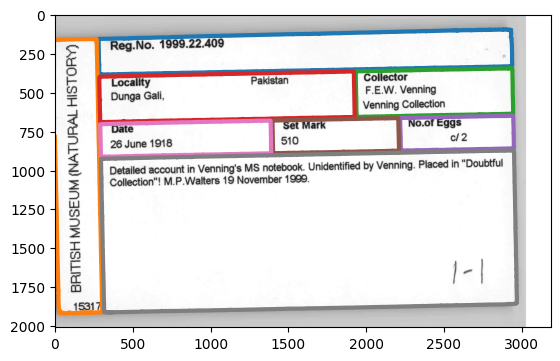

In [11]:
fig,ax = plt.subplots()
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY),cmap='gray')
final_contours = []
for contour in contours_grey:
    if len(contour[:,0]) > 50:
        range_x = max(contour[:,1])-min(contour[:,1])
        range_y = max(contour[:,0])-min(contour[:,0])
        area = cv2.contourArea(contour.astype(int))
        if ((range_x > xb) or (range_y > yb)) and (area > area_lower_bound):
            X,Y = contour[:,1],contour[:,0]
            if X[0] == X[-1]:
                ax.plot(X,Y,linewidth=3)
                final_contours.append([X,Y])

### All-in-one Box Segmenting Function

In [12]:
def get_box_contours(image):
    image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contours_grey = measure.find_contours(image_grey/255, 0.8)
    xb,yb = get_max_bounds(contours_grey,xbound=8)
    area_lower_bound = (xb*yb)/5
    final_contours = []
    for contour in contours_grey:
        if len(contour[:,0]) > 50:
            range_x = max(contour[:,1])-min(contour[:,1])
            range_y = max(contour[:,0])-min(contour[:,0])
            area = cv2.contourArea(contour.astype(int))
            if ((range_x > xb) or (range_y > yb)) and (area > area_lower_bound):
                X,Y = contour[:,1],contour[:,0]
                if X[0] == X[-1]:
                    final_contours.append([X,Y])
    return final_contours

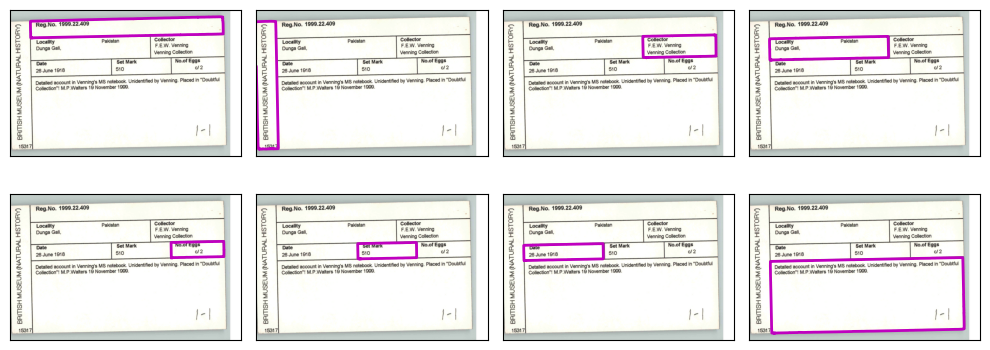

In [13]:
fig,ax = plt.subplots(2,4,figsize=(10,5),layout='tight')

k = 0

for i,xy in enumerate(final_contours):
    if (i%4==0) and (i>0):
        k = 1
    j = i%4
    ax[k,j].imshow(image)
    ax[k,j].plot(xy[0],xy[1],'m',linewidth='2')
    ax[k,j].get_xaxis().set_ticks([])
    ax[k,j].get_yaxis().set_ticks([])

### Vertical vs Horizontal Boxes

Detecting whether a box is vertical or horizontal.

In [14]:
C = get_box_contours(image)

[]

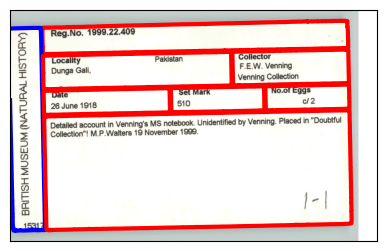

In [15]:
fig,ax = plt.subplots(figsize=(5,3))
ax.imshow(image)

for c in C:
    rx = max(c[0])-min(c[0])
    ry = max(c[1])-min(c[1])
    if rx > ry:
        col = 'r'
    else:
        col = 'b'
    ax.plot(c[0],c[1],linewidth=3,color=col)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

## Detecting Text  / Text Orientation

_Horizontal boxes_ have horizontal text, but _vertical boxes_ can have text from varying orientations. 

### Tests with Tesseract Only
Here, we manually rotate the image 0,90,180,270 degrees and extract the text from the rotated image.

In [16]:
c = C[1]

minx = int(min(c[0]))
maxx = int(max(c[0]))
miny = int(min(c[1]))
maxy = int(max(c[1]))

img_cropped = image[miny:maxy,minx:maxx]

In [17]:
for r in [0,90,180,270]:
    img_r = imutils.rotate_bound(img_cropped, r)
    ocr_results = pytesseract.image_to_string(img_r, config="--psm 11 script=Latin")
    print('--------------------')
    print("Rotated Angle - "+str(r)+":")
    print('--------------------\n')
    print(ocr_results)

--------------------
Rotated Angle - 0:
--------------------

15317

--------------------
Rotated Angle - 90:
--------------------

BRITISH MUSEUM (NATURAL HISTORY)

g

--------------------
Rotated Angle - 180:
--------------------

Liesl

--------------------
Rotated Angle - 270:
--------------------

SN

=_

YN) ANSSNA HSL =

&

(HOLSIH WHn



### Tests with Craft

In [18]:
from craft_text_detector import Craft

In [19]:
image_path = '/home/arias1/Documents/GitHub/egg_cards/Images/Drawer_1/Usable/001-0001.jpg'
output_dir = 'outputs/'

In [21]:
# create a craft instance
craft = Craft(output_dir=output_dir, crop_type="poly", cuda=False)

# apply craft text detection and export detected regions to output directory
prediction_result = craft.detect_text(image_path)

# unload models from ram/gpu
craft.unload_craftnet_model()
craft.unload_refinenet_model()

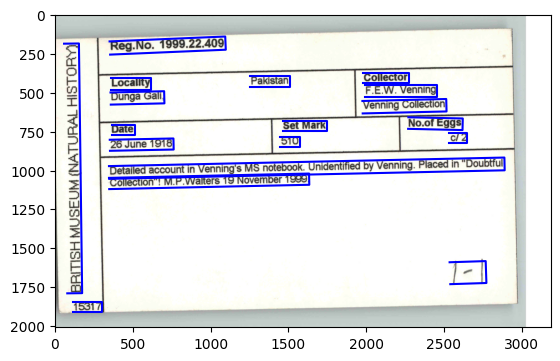

In [22]:
fig,ax = plt.subplots()
ax.imshow(image)
for box in prediction_result['boxes']:
    ax.plot(box[:,0],box[:,1],'-b')

### Combining Craft Textboxes & Segmented Boxes

In [24]:
def get_box_details(c):
    minx = min(c[0])
    maxx = max(c[0])
    miny = min(c[1])
    maxy = max(c[1])
    return minx,maxx,miny,maxy

In [25]:
def get_textbox_details(box):
    X,Y = box[:,0],box[:,1]
    minx = min(X)
    maxx = max(X)
    miny = min(Y)
    maxy = max(Y)
    return minx,maxx,miny,maxy

In [70]:
def detect_orientation(x,y):
    # classify whether a box/textbox is horizontal or vertical
    rx = max(x)-min(x)
    ry = max(y)-min(y)
    if rx > ry:
        orientation = 'h'
    else:
        orientation = 'v'
        
    return orientation

In [49]:
cols = ['k','g','y','r','b','m','c','brown','salmon','gray','darkgreen','indigo']

[]

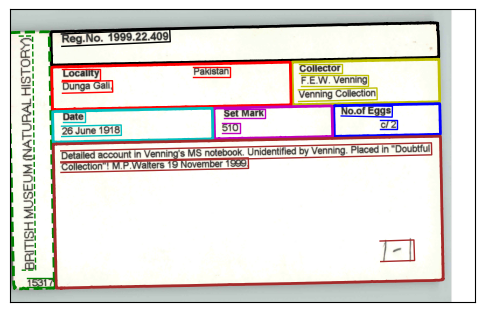

In [69]:
fig,ax = plt.subplots(figsize=(6,5))
ax.imshow(image)

leeway = 10

plotted_textboxes = []

for i,c in enumerate(C):
    # Segmented box details:
    box_minx,box_maxx,box_miny,box_maxy = get_box_details(c)
    # Plot box:
    horizontal_or_vertical = detect_orientation(c[0],c[1])
    if horizontal_or_vertical == "h":
        pattern = '-'
    else:
        pattern = '--'
    ax.plot(c[0],c[1],linestyle=pattern,linewidth=2,color=cols[i])
    
    # Loop through textboxes:
    for j,box in enumerate(prediction_result['boxes']):
        # Get text box details:
        textbox_minx,textbox_maxx,textbox_miny,textbox_maxy = get_textbox_details(box)
        if all(((textbox_minx>=box_minx-leeway),(textbox_maxx<=box_maxx+leeway),
                (textbox_miny>=box_miny-leeway),
                (textbox_maxy<=box_maxy+leeway))) and (j not in plotted_textboxes):
            # Plot textbox:
            horizontal_or_vertical = detect_orientation(box[:,0],box[:,1])
            if horizontal_or_vertical == "h":
                pattern = '-'
            else:
                pattern = '--'
            ax.plot(box[:,0],box[:,1],linestyle=pattern,color=cols[i],linewidth=1)
            plotted_textboxes.append(j)


ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

#### Image Cropping

In [81]:
def crop_image(image,box_x,box_y,leeway=0):
    mY,mX = np.shape(image)[:2] 
    minx = max([int(min(box_x))-leeway,0])
    maxx = min([int(max(box_x))+leeway,mX])
    miny = max([int(min(box_y))-leeway,0])
    maxy = min([int(max(box_y))+leeway,mY])

    img_cropped = image[miny:maxy,minx:maxx]
    
    return img_cropped

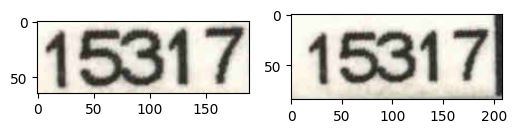

In [85]:
fig,ax = plt.subplots(1,2,figsize=(6,3))
image_cropped = crop_image(image,box[:,0],box[:,1])
ax[0].imshow(image_cropped)
image_cropped = crop_image(image,box[:,0],box[:,1],leeway=10)
ax[1].imshow(image_cropped)

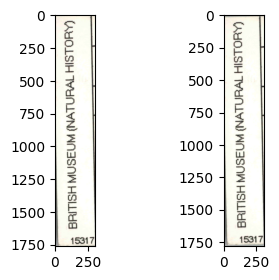

In [84]:
fig,ax = plt.subplots(1,2,figsize=(4,3))
c = C[1]
image_cropped = crop_image(image,c[0],c[1])
ax[0].imshow(image_cropped)
image_cropped = crop_image(image,c[0],c[1],leeway=10)
ax[1].imshow(image_cropped)

### Combining Tesseract

In [150]:
def get_text(image,box_x,box_y,leeway=0):
    # 1) Classify box as horizontal or vertical:
    horizontal_or_vertical = detect_orientation(box_x,box_y)
    # 2) Crop image:
    image_cropped = crop_image(image,box_x,box_y,leeway=leeway)
    # 3) Find text:
    # If box is horizontal, we assume text is written the right way up.
    # For vertical boxes, we take the longest text found when rotated.
    if horizontal_or_vertical == "h":
        ocr_results = pytesseract.image_to_string(image_cropped, config="--psm 11 script=Latin")
    else:
        # Rotate 90 degrees:
        rotated_image = imutils.rotate_bound(image_cropped, 90)
        ocr_results = pytesseract.image_to_string(rotated_image, config="--psm 11 script=Latin")
        # Rotate 270 degrees:
        rotated_image_270 = imutils.rotate_bound(image_cropped, 270)
        ocr_results_270 = pytesseract.image_to_string(rotated_image_270, config="--psm 11 script=Latin")
        if len(ocr_results_270) > len(ocr_results):
            ocr_results = deepcopy(ocr_results_270)
            rotated_image = deepcopy(rotated_image_270)
        image_cropped = deepcopy(rotated_image)
    return ocr_results,image_cropped

In [101]:
# ASJ note: Taken from ALICE code.
def get_osd(image, min_char_values=[3,4,5,6]):
    max_total = min(min_char_values)
    osd = "N/A"
    for j in min_char_values:
        try:
            osd = pytesseract.image_to_osd(
                image,
                config="--psm 0 -c min_characters_to_try=" + str(j) + " script=Latin",
            )
            max_total = j
        except:
            pass
    # Get orientation confidence score:
    k1 = re.search("Orientation confidence: ", osd).span()[1]
    k2 = re.search("Script", osd).span()[0]
    prct = float(osd[k1 : k2 - 1])
    return osd, prct

#### OCR on Textboxes
(Using tesseract to extract from individual textboxes within boxes.)

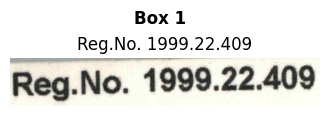

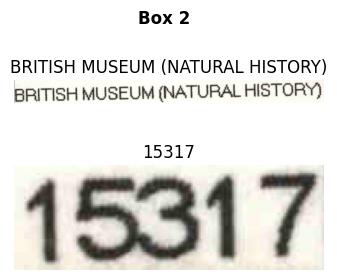

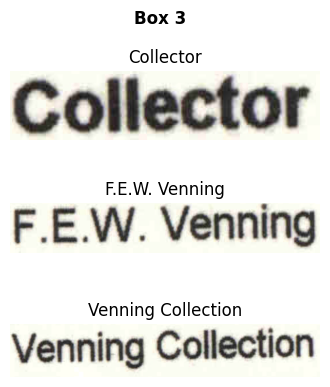

In [154]:
for u,c in enumerate(C[:3]):
    box_minx,box_maxx,box_miny,box_maxy = get_box_details(c)
    # Loop through textboxes:
    all_text = []
    all_images = []
    for j,box in enumerate(prediction_result['boxes']):
        # Get text box details:
        textbox_minx,textbox_maxx,textbox_miny,textbox_maxy = get_textbox_details(box)
        if all(((textbox_minx>=box_minx-leeway),(textbox_maxx<=box_maxx+leeway),
                    (textbox_miny>=box_miny-leeway),
                    (textbox_maxy<=box_maxy+leeway))):
            ocr,I = get_text(image,box[:,0],box[:,1])
            all_text.append(ocr.replace('\n','').replace('\x0c', ''))
            all_images.append(I)
    n = len(all_images)
    fig,axes = plt.subplots(n,1,figsize=(4,1.5*n))
    for i,I in enumerate(all_images):
        if n>1:
            ax = axes[i]
        else:
            ax = axes
        ax.imshow(I)
        ax.set_title(all_text[i])
        ax.axis('off')
    plt.suptitle('Box '+str(u+1),weight='bold')

#### OCR on Boxes
(Using tesseract to extract from within boxes.)
Here, if a box contains multiple textboxes (from Craft) that have varying orientation, then text will be extracted from the text boxes individually, in those cases.

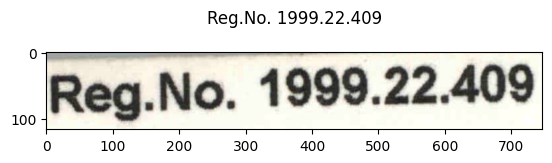

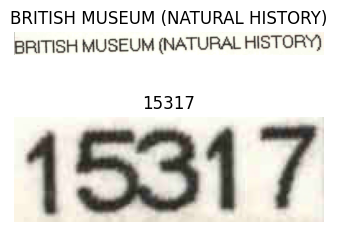

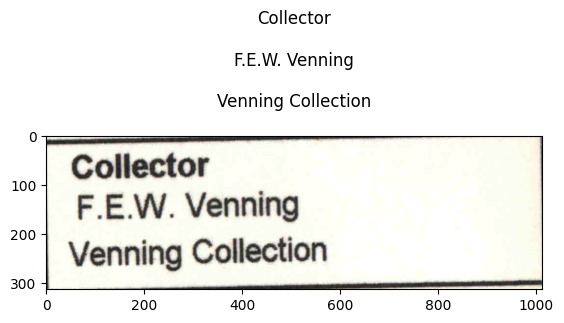

In [166]:

for u,c in enumerate(C[:3]):
    box_minx,box_maxx,box_miny,box_maxy = get_box_details(c)
    # Loop through textboxes:
    all_boxes = []
    all_h_or_v = []
    for j,box in enumerate(prediction_result['boxes']):
        # Get text box details:
        textbox_minx,textbox_maxx,textbox_miny,textbox_maxy = get_textbox_details(box)
        if all(((textbox_minx>=box_minx-leeway),(textbox_maxx<=box_maxx+leeway),
                    (textbox_miny>=box_miny-leeway),
                    (textbox_maxy<=box_maxy+leeway))):
            horizontal_or_vertical = detect_orientation(box[:,0],box[:,1])
            all_h_or_v.append(horizontal_or_vertical)
            all_boxes.append(box)
    
    if "v" not in all_h_or_v:
        if len(all_boxes) == 1:
            # If there's only one horizontal text box within a box, use textbox for ocr.
            box = all_boxes[0]
            ocr,I = get_text(image,box[:,0],box[:,1])
        else:
            ocr,I = get_text(image,c[0],c[1])
        fig,ax = plt.subplots()
        ax.imshow(I)
        ax.set_title(ocr.replace('\x0c', ''))
    else:
        all_text = []
        all_images = []
        for box in all_boxes:
            ocr,I = get_text(image,box[:,0],box[:,1])
            all_text.append(ocr.replace('\n','').replace('\x0c', ''))
            all_images.append(I)
        n = len(all_images)
        fig,axes = plt.subplots(n,1,figsize=(4,1.5*n))
        for i,I in enumerate(all_images):
            if n>1:
                ax = axes[i]
            else:
                ax = axes
            ax.imshow(I)
            ax.set_title(all_text[i])
            ax.axis('off')